# Week 04: Multi-class Classification

## Introduction


In this exercise, we will implement logistic regression based multiclass classification to recognize handwritten digits. 

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# Module to load MATLAB .mat datafile format (Input and output module of scipy)
from scipy.io import loadmat

# Python Imaging Library (PIL)
from PIL import Image

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Multi-class Classification

For this exercise, logistic regression will be used to recognize handwritten digits (from 0 to 9).

### Dataset

The data set is given in `mnist-digit.mat` that contains 5000 training examples of handwritten digits. Use the function `loadmat` within the `scipy.io` module to load the data.

There are 5000 training examples in `mnist-digit.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set.



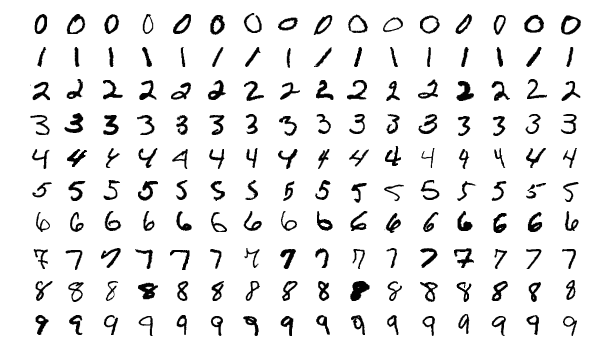

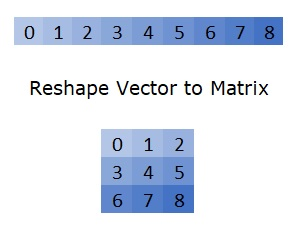

In [2]:
# Load data

digits = loadmat('data/mnist-digit.mat')



# 10 labels, from 1 to 10 (note that you have to map "0" to label "10")

# printing out all the keys
print(sorted(digits.keys()))

# printing the unique values of the labels
print(np.unique(digits["y"]))

# mapping 0 to label 10
digits["y"][digits["y"] == 10] = 0

# printing the unique values of the labels
np.unique(digits["y"])



['X', '__globals__', '__header__', '__version__', 'y']
[ 1  2  3  4  5  6  7  8  9 10]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [3]:
# check the shape of the data
print(digits["X"].shape) 
print(digits["y"].shape)

(5000, 400)
(5000, 1)


### MATLAB Data

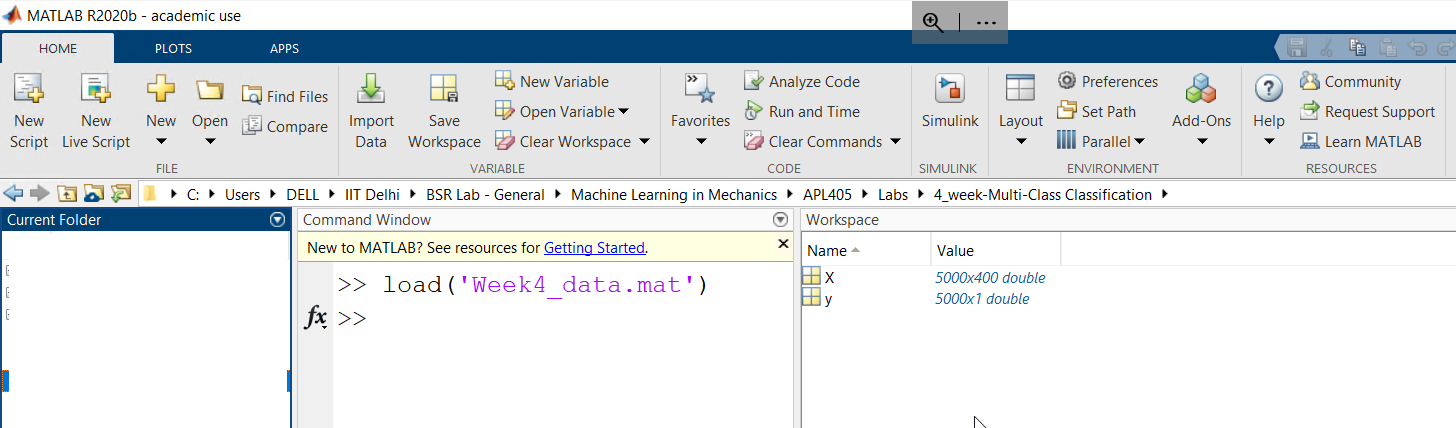

### Definition of useful functions that are going to be used thoughout the code

In [4]:
def displayData(X):
    """
    Displays the data from X
    """
    # number of images to display
    m = X.shape[0]
    
    # number of pixels in each image
    n = X.shape[1]
    
    # number of images to display in each row
    example_width = int(np.round(np.sqrt(n)))
    
    # number of images to display in each column
    example_height = int(n / example_width)
    
    # compute the number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    
    # between images padding
    pad = 1
    
    # setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))
    
    # copy each example into a patch on the display array
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break
            
            # copy the patch
            
            # get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]))
            rows = pad + j * (example_height + pad) + np.array(range(example_height))
            cols = pad + i * (example_width + pad) + np.array(range(example_width))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = X[curr_ex, :].reshape(example_height, example_width) / max_val
            curr_ex = curr_ex + 1
            
        if curr_ex > m:
            break
    
    # display image
    pyplot.imshow(display_array, cmap='gray')
    
    # Do not show axis
    pyplot.axis('off')
    
    pyplot.show()
    
#=========================================================================================        
        
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

### Visualize the data

To visualize the data that you imported, randomly selects 100 rows from `X` and passes those rows to the `displayData` function.

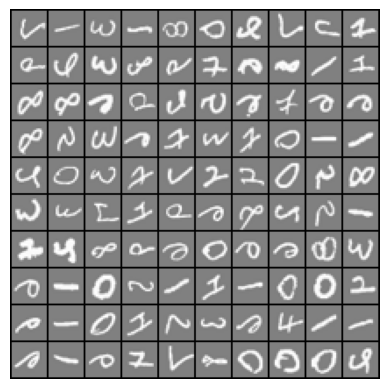

In [5]:
# Randomly select data points to display

# number of images to display
m = digits["X"].shape[0]
sel = np.random.choice(m, 100, replace=False)

# display the images
displayData(digits["X"][sel, :])

<a id="section1"></a>
#### Vectorizing the cost function 

Begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_w\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_w \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_w(x^{(i)})$ for every example $i$, where $h_w(x^{(i)}) = g(w^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $w$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad w = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{bmatrix} $$

Then, by computing the matrix product $Xw$, we have: 

$$ Xw = \begin{bmatrix} - \left( x^{(1)} \right)^Tw - \\ - \left( x^{(2)} \right)^Tw - \\ \vdots \\ - \left( x^{(m)} \right)^Tw - \end{bmatrix} = \begin{bmatrix} - w^T x^{(1)}  - \\ - w^T x^{(2)} - \\ \vdots \\ - w^T x^{(m)}  - \end{bmatrix} $$

#### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_w\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $w_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial w_0} \\
\frac{\partial J}{\partial w_1} \\
\frac{\partial J}{\partial w_2} \\
\vdots \\
\frac{\partial J}{\partial w_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_w(x) - y\right)
\end{align*}
$$

where

$$  h_w(x) - y = 
\begin{bmatrix}
h_w\left(x^{(1)}\right) - y^{(1)} \\
h_w\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_w\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_w\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_w\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_w(x^{(i)} - y^{(i)} \right)$.

Now the job is to define a new function (`lrCostFunction`) which will take the data (vectors `X` and `y`) and parameter (`Lambda`) as input and return the cost as a scalar. 

#### Regularized logistic regression

Now add regularization to the cost function. For regularized logistic regression, the cost function is defined as

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_w\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_w \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Note that $w_0$ should not be regularized as it is used as bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $w_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} w_j & \text{for } j  \ge 1
\end{align*}
$$

In [6]:
def lrCostFunction(w, X, y, lambda_):

    # y = y.flatten()
    
    # number of training examples
    m = y.size

    # if labels are Yes/No, map 0/1 to Yes/No.
    if y.dtype == bool:
        y = y.astype(int)
        
    # initialize the cost and gradient
    J = 0
    grad = np.zeros(w.shape)
    
    # hypothesis function (sigmoid) 
    
    h = sigmoid(np.dot(X,w.T))
    # return h
    
    # cost function (regularized) 
    J = (1/m)*np.sum(-y*np.log(h)-(1-y)*np.log(1-h)) + (lambda_/(2*m))*np.sum(w[1:]**2)
    # print(J)

    
    # gradient (regularized)
    grad = (1/m)*np.dot(X.T,(h-y)) + (lambda_/m)*np.r_[[[0]],w[1:].reshape(-1,1)].reshape(-1,)
    
    return J, grad

<a id="section2"></a>
### Multi-class Classification

In this part of the exercise, you will implement multi-class classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset.

Code for the function `oneVsAll` below, to train one classifier for each class. In particular, the code should return all the classifier parameters in a matrix $w \in \mathbb{R}^{K \times (N +1)}$, where each row of $w$ corresponds to the learned logistic regression parameters for one class. One can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

The obvious approach is to use a one-versus-the-rest approach (also called one-vs-all), in which we train C binary classifiers, fc(x), where the data from class c is treated as positive, and the data from all the other classes is treated as negative.

<a id="oneVsAll"></a>

In [7]:
def oneVsAll(X, y, num_labels, lambda_):
        
    # number of training examples and features
    m, n = X.shape
    
    # initialize the weights to all zeros (one weight per label), shape (num_labels, n + 1)
    all_w = np.zeros((num_labels, n + 1))

    # add ones to the X data matrix (bias term)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    ress = []
    
    for c in np.arange(num_labels):
        initial_w = np.random.uniform(low=-1, high=1,size=n + 1)
        res = optimize.minimize(lrCostFunction, initial_w, (X, (y == c), lambda_), jac=True, options={'maxiter':50000}, tol=1e-10, method="CG")
        all_w[c] = res.x
        ress.append(res)
    return all_w, ress

After complting the code for `oneVsAll`, the following cell shall use the code to train a multi-class classifier. 

In [8]:
np.random.seed(42)
lambda_ = 0.6
X = digits["X"]/max(digits["X"].flatten())
y = digits["y"].reshape(-1,)
all_w, r = oneVsAll(X, y, 10, lambda_)
print(all_w.shape) # 10 X 401

(10, 401)


<a id="section3"></a>
#### Multi-class Prediction

After training one-vs-all classifier, one can now use it to predict the digit contained in a given image. For each input, one should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example.
<a id="predictOneVsAll"></a>

In [12]:
def predictOneVsAll(all_w, X):
        
    m = X.shape[0]
    num_labels = all_w.shape[0]

    # Return the following variable 
    p = np.zeros(m)

    # add ones to the X data matrix (bias term)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # retrun the class with max prob 
    p = np.argmax(sigmoid(np.dot(X,all_w.T)), axis=1)   # A vector of size 10 X 1 -> Keep in the class having max prob
    
    return p

Now, call `predictOneVsAll` function using the learned value of $w$. One should see the training set accuracy in percentage which shows that the algorithm classifies `p%` of the examples in the training set correctly.

In [13]:
pred = predictOneVsAll(all_w, X)
accuracy  = np.mean(pred == y) * 100
print('Training Set Accuracy: {:.2f}%'.format(accuracy) )

Training Set Accuracy: 94.58%
